In [1]:
import numpy as np
import h5py
import csv
import os
import re
import matplotlib.pyplot as plt
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter


In [2]:
# cs_indices_csv = '../data/OpenEphys_data/2019-03-26/2019-03-26_17-40-47/channel_5.CS.csv'


In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [21]:
# source_path = '../data/OpenEphys_data/2019-03-26/2019-03-26_17-40-47/'
# source_path = '../data/OpenEphys_data/2019-03-26/2019-03-26_18-27-55/'
# source_path = '../data/OpenEphys_data/2019-03-27/2019-03-27_13-58-03/'
source_path = '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/'
chan_index = 5

num_channels = 7
chan_index = chan_index - 1
raw_data = source_path + 'raw_data'
analyzed_data = source_path + 'analyzed_data'


In [22]:
f_names = []
f_names_cmn = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*(CH)(\d)\.mat$")
        f_cmn_regex = re.compile(r".*(CMN)(\d)\.mat$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
        if f_cmn_regex.match(filename):
            f_names_cmn = f_names_cmn + [os.path.join(root, filename)]
        
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][-1:]) for f in f_names]

f_names = f_names[np.argsort(chans)] # now sorted by channel number

f_names_cmn = np.array(f_names_cmn)

import h5py
f = h5py.File(f_names[chan_index])
chan_data = np.squeeze(np.array(f['ch_data']))
Fs = np.array(f['ch_info']['header']['sampleRate'])[0][0]
chan_data = butter_bandpass_filter(chan_data, 200, 10000, Fs, order=2 )

print(f_names_cmn[0])
f = h5py.File(f_names_cmn[0])
chan_cmn = np.squeeze(np.array(f['ch_data']))
chan_cmn = butter_bandpass_filter(chan_cmn, 200, 10000, Fs, order=2 )

chan_data = chan_data - chan_cmn

../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/raw_data/101_CMN1.mat


In [24]:
f_names = []
f_names_cmn = []
for root, dirnames, filenames in os.walk(analyzed_data):
    for filename in filenames:
        
        f_regex = re.compile(r".*\.mat$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]

f_names = np.array(f_names)

f_names

f = h5py.File(f_names[1])


cs_ind_PS = np.squeeze(np.array(f['CS_data']['CS_ind']))

f_name_csv = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    cs_indices = np.squeeze(np.array(list(reader), dtype=np.int64))

FileNotFoundError: [Errno 2] No such file or directory: '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/channel_4.CS.csv'

In [25]:
f_names

array(['../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/analyzed_data/190409_152524_REDUCED.mat',
       '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/analyzed_data/190409_152524_05_sorted.mat',
       '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/analyzed_data/190409_152524_07_sorted.mat',
       '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/analyzed_data/190409_152524_ANALYZED.mat',
       '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/analyzed_data/190409_152524_03_sorted.mat',
       '../data/OpenEphys_data/2019-04-09/2019-04-09_15-25-24/analyzed_data/190409_152524_EVE1_aligned.mat'],
      dtype='<U98')

<IPython.core.display.Javascript object>


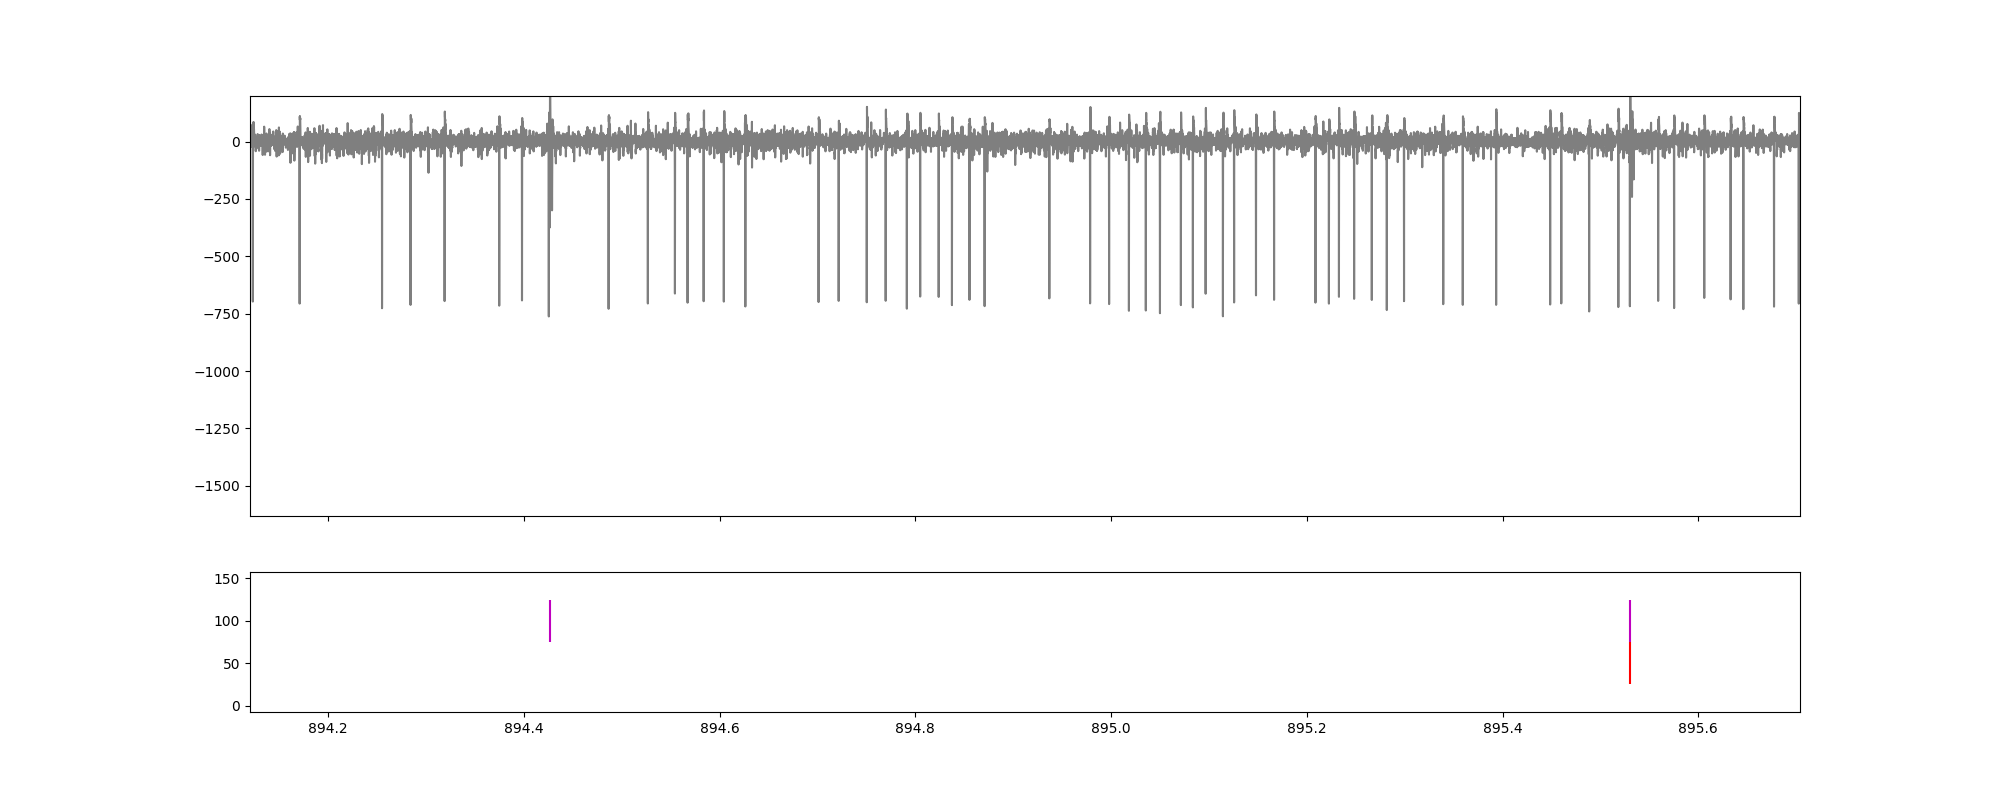

In [17]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

# prange = [0,chan_data.size*1.0/Fs]
# prange = [chan_data.size*1.0/Fs - 100, chan_data.size*1.0/Fs] #s
prange = [500,1000] #s
idx_voltage = [int(pr*Fs) for pr in prange]
ax0.plot(np.arange(prange[0],prange[1],1/Fs), chan_data[idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*1.0/Fs, linelengths=50, lineoffsets=50, color='r')
ax1.eventplot(cs_ind_PS[np.where(np.logical_and(cs_ind_PS < idx_voltage[1] , cs_ind_PS >= idx_voltage[0]))]*1.0/Fs, linelengths=50, lineoffsets=100, color='m')
# plt.plot(chan_data[chan_index,::10])

In [18]:
plt.savefig('../data/plots/tmp/mismatched_cs3.png')

In [15]:
cs_indices2 = cs_indices[np.where(cs_indices > 400*Fs)]
cs_ind_PS2 = cs_ind_PS[np.where(cs_ind_PS > 400*Fs)]

In [7]:
search_zone = 0.0005 #s
csi_in_ps = np.zeros(cs_indices.size)
for i, csi in enumerate(cs_indices):
    csi_in_ps[i] = np.where( np.logical_and(cs_ind_PS < csi + search_zone*Fs, cs_ind_PS > csi - search_zone*Fs))[0].size != 0

psi_in_css = np.zeros(cs_ind_PS.size)
for j, psi in enumerate(cs_ind_PS):
    psi_in_css[j] = np.where( np.logical_and(cs_indices < psi + search_zone*Fs, cs_indices > psi - search_zone*Fs))[0].size != 0
    

print('True positives (CSsorter based on PS) = {}'.format(np.sum(csi_in_ps)/cs_ind_PS.size))
print('False Negatives (CSsorter based on PS) = {}'.format((cs_ind_PS.size - np.sum(psi_in_css))/cs_ind_PS.size))


print('True positives (PS based on CSsorter) = {}'.format(np.sum(psi_in_css)/cs_indices.size))
print('False Negatives (PS based on CSsorter) = {}'.format((cs_indices.size - np.sum(psi_in_css))/cs_indices.size))


True positives (CSsorter based on PS) = 0.8369611609048229
False Negatives (CSsorter based on PS) = 0.16303883909517713
True positives (PS based on CSsorter) = 0.9949264332825977
False Negatives (PS based on CSsorter) = 0.0050735667174023336


In [16]:
search_zone = 0.0005 #s
csi_in_ps = np.zeros(cs_indices2.size)
for i, csi in enumerate(cs_indices2):
    csi_in_ps[i] = np.where( np.logical_and(cs_ind_PS2 < csi + search_zone*Fs, cs_ind_PS2 > csi - search_zone*Fs))[0].size != 0

psi_in_css = np.zeros(cs_ind_PS2.size)
for j, psi in enumerate(cs_ind_PS2):
    psi_in_css[j] = np.where( np.logical_and(cs_indices2 < psi + search_zone*Fs, cs_indices2 > psi - search_zone*Fs))[0].size != 0
    

print('True positives (CSsorter based on PS) = {}'.format(np.sum(csi_in_ps)/cs_ind_PS2.size))
print('False Negatives (CSsorter based on PS) = {}'.format((cs_ind_PS2.size - np.sum(psi_in_css))/cs_ind_PS2.size))


print('True positives (PS based on CSsorter) = {}'.format(np.sum(psi_in_css)/cs_indices2.size))
print('False Negatives (PS based on CSsorter) = {}'.format((cs_indices2.size - np.sum(psi_in_css))/cs_indices2.size))


True positives (CSsorter based on PS) = 0.9274530271398748
False Negatives (CSsorter based on PS) = 0.07254697286012526
True positives (PS based on CSsorter) = 0.998314606741573
False Negatives (PS based on CSsorter) = 0.0016853932584269663
